# Homework 7: Analytical Orbit

Colin Weber

In [4]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# import CenterOfMass to determine the COM pos/vel of M33

from CenterOfMass import CenterOfMass
# import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass

# M33AnalyticOrbit

In [6]:
class M33AnalyticOrbit:
    """ Calculates the analytical orbit of M33 around M31 """
    def __init__(self,file):
        """ This function initializes the variable that will be used in the class for the galaxy
        Inputs: 
            file: 'string', inputs that data for the galaxy that will be used
        
        """
        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2)
        ###store the output file name
        self.filename = file
        ### get the current pos/vel of M33 
        # create an instance of the  CenterOfMass class for M33 
        COM_M33 = CenterOfMass("M33_000.txt", 2)
        # store the position VECTOR of the M33 COM
        self.M33_COM_p = COM_M33.COM_P(0.1) 
        # store the velocity VECTOR of the M33 COM
        self.M33_COM_v = COM_M33.COM_V(self.M33_COM_p[0],self.M33_COM_p[1],self.M33_COM_p[2]).value
        ### get the current pos/vel of M31 
        # create an instance of the CenterOfMass class for M31
        COM_M31 = CenterOfMass("M31_000.txt", 2)
        # store the position VECTOR of the M31 COM (.value to get rid of units)
        self.M31_COM_p = COM_M31.COM_P(0.1)
        # store the velocity VECTOR of the M31 COM (.value to get rid of units)
        self.M31_COM_v = COM_M31.COM_V(self.M31_COM_p[0],self.M31_COM_p[1],self.M31_COM_p[2]).value
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r0 = np.array([self.M33_COM_p[0].value-self.M31_COM_p[0].value,self.M33_COM_p[1].value-self.M31_COM_p[1].value,
                            self.M33_COM_p[2].value-self.M31_COM_p[2].value])
        self.v0 = np.array([self.M33_COM_v[0]-self.M31_COM_v[0],self.M33_COM_v[1]-self.M31_COM_v[1],
                            self.M33_COM_v[2]-self.M31_COM_v[2]])
        ### get the mass of each component in M31 
        ### disk
        self.rdisk = 5 * u.kpc
        # **** self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = 0.12e12 * u.Msun
        ### bulge
        self.rbulge = 1 * u.kpc
        # self.Mbulge  set with ComponentMass function.
        self.Mbulge = 0.019e12 * u.Msun
        # Halo
        self.rhalo = 62 * u.kpc
        # self.Mhalo set with ComponentMass function.
        self.Mhalo = 1.921e12 * u.Msun
    def HernquistAccel(self,M,r_a,r): # it is easiest if you take as an input the position VECTOR 
        """ 
        This function determines the acceleration vector using the Hernquist formula
        for the halo and bulge components of the galaxies relative to eachother
        Inputs:
            M: 'int', the mass of the object
            r_a: 'int', the scale distance of the object
            r: 'array', the distance between the two galaxies, represented as a vector
        Outputs:
            Hern: 'array', the acceleration vector between the two galaxies
        """
        # Computes the magnitude of the position from the distance r.
        rmag = np.sqrt(r[0]**2+r[1]**2+r[2]**2) * u.kpc
        
        r = r * u.kpc #assigns units to r
        Hern = -self.G * M/(rmag*((r_a+rmag)**2)) * r  #Uses the Hernquist equation to calculate the acceleration vector
        return Hern
    def MiyamotoNagaiAccel(self,M,r_d,r):# it is easiest if you take as an input a position VECTOR  r 
        """ This function determines the acceleration vector using a Miyamoto-Nagai profile
        for the disk component of the galaxies relative to eachother.
        Inputs:
            M: 'int', the mass of the object
            r_d: 'int', the scale distance of M31
            r: 'array', the distance between the two galaxies, represented as a vector
        Outputs:
            a: 'array', the acceleration vector between the two galaxies"""
        
        r = r * u.kpc # assigns units to r
        
        R = np.sqrt(r[0]**2+r[1]**2) # simplifies the profile, represents the magnitude of the distance on the z = 0 plane
        B = r_d + np.sqrt(r[2]**2+(r_d/5)**2) # simplifies the profile more
        z0 = B/np.sqrt(r[2]**2+(r_d/5)**2) # calculates the additional part of the equation for the z vector
        array = np.array([1,1,z0])
        # Calculate the acceleration using the Miyamoto-Nagai profile
        a = -self.G*M/((R**2+B**2)**1.5)*r*array
        return a

    
    def M31Accel(self,r): # input should include the position vector, r
        """ This function computes the total acceleration vector between the two galaxies by
        combining the acceleration vectors of the three components.
        used the formula a_tot = (Sigma_n(a_n*m_n))/(Sigma_n(m_n))
        Imputs:
            r: 'array', the distance between the two galaxies, represented as a vector
        Outputs:
            acc: 'array', the total acceleration vector between the two galaxies"""
        # Calls on HernquistAccel to Compute the halo acceleration vector between the two galaxies
        ahalo = self.HernquistAccel(self.Mhalo,self.rhalo,r)
        #Calls on HernquistAccel to Compute the bulge acceleration vector between the two galaxies
        abulge = self.HernquistAccel(self.Mbulge,self.rbulge,r)
        # Calls on MiyamotoAccel to Compute the disk acceleration vector between the two galaxies
        adisk = self.MiyamotoNagaiAccel(self.Mdisk,self.rdisk,r)
        # gets the mass of each component
        Mh = self.Mhalo
        Mb = self.Mbulge
        Md = self.Mdisk
        # gets the total mass, = \Sigma_n(m_n)
        M_tot = Mh+Mb+Md
        # computes the total acceleration vector
        acc = (ahalo*Mh+abulge*Mb+adisk*Md)/M_tot
        ### Call the previous functions for the halo, bulge and disk
        # these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc.
        # return t SUM of the output of the acceleration functions - this will return a VECTOR 
        return acc
    
    
    
    def LeapFrog(self,deltat,r,v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """ This function uses the current position, velocity, and acceleration vectors to
        predict the future motion of the galaxies
        Inputs:
            deltat: 'int', the change in time between the initial position/velocity vectors and 
            the predicted position/velocity vectors
            r: 'array', the distance between the two galaxies, represented as a vector
            v: 'array', the velocity between the two galaxies, represented as a vector
        Outputs:
            rnew: 'array', the new distance vector between the galaxies after time deltat
            vnew: 'array', the new velocity vector between the galxies after time deltat
        """
        
        # predict the position at the next half timestep
        rhalf = r + v*(deltat/2)
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v + (self.M31Accel(rhalf).value)*deltat
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = r + 0.5*(v+vnew)*deltat
        
        return rnew,vnew
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """ This function uses LeapFrog to create a file that stores the analytical evolution of the galaxies during the galaxy merger.
        Each row in the file contains the time and the x,y, znd z components of both position and velocity.
        Inputs:
            t0: 'int', the earliest time where position and velocity are being stored
            dt: 'int', the difference in time between row in the file
            tmax: 'int', the last point in time where the distance and velocity vectors are computed
        """

        # initialize the time to the input starting time
        t = t0
        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros((int(tmax/dt)+2,7))
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t<=tmax):  # as long as t has not exceeded the maximal time 
            
            # advance the time by one timestep, dt
            t = t+dt
            # store the new time in the first column of the ith row
            orbit[i][0] = t0 + (i)*dt
            
            # gets the most recent projected position and velocity of the galaxy
            r = np.array([orbit[i-1][1],orbit[i-1][2],orbit[i-1][3]])
            v = np.array([orbit[i-1][4],orbit[i-1][5],orbit[i-1][6]])
            #advance the position and velocity using the LeapFrog scheme
            rn,vn = self.LeapFrog(dt,r,v)

            # store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            orbit[i][1] = rn[0]
            orbit[i][2] = rn[1]
            orbit[i][3] = rn[2]
            
            # store the new velocity vector into the columns with indexes 4,5,6 of the ith row of orbit
            
            orbit[i][4] = vn[0]
            orbit[i][5] = vn[1]
            orbit[i][6] = vn[2]
            # update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i = i + 1
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        

In [8]:
# Calls on Orbitintegration to create the file named "file1"
# That stores the time, position, and velocity between the galaxies as time goes on
# From 0 to 10 Gigayears with 0.1 Gigayears in between each row
M33AnalyticOrbit('file1').OrbitIntegration(0,0.1,10)

In [9]:
# Loads in the file just created
data = np.genfromtxt("file1",dtype=None,names=True)

In [10]:
def graph(file):
    """ This function is meant to make the data from the table easy to graph by returning lists
    containing the time, position magnitude, and velocity magnitude.
    inputs:
        file: 'string', the name of the file that I want to graph data from
    outputs:
        dist: 'list', a list containing the magnitude of the distance between the two galaxies for each time computed
        vel: 'list', a list containing the magnitude of the velocity between the two galaxies for each time computed
        time: 'list', a list containing each time where the distance and velocity between the galaxies was computed
    """
    # uses np.zeros to make empty lists for each variable
    dist = np.zeros(len(file))
    vel = np.zeros(len(file))
    time = np.zeros(len(file))
    #creates a for loop that replaces the zeros on each list with the 
    # time for time, distance magnitude for dist, and velocity magnitude for vel
    for i in range(len(file)):
        t = file[i][0]
        x = file[i][1]
        y = file[i][2]
        z = file[i][3]
        vx = file[i][4]
        vy = file[i][5]
        vz = file[i][6]
        time[i] = t
        # computes and inserts the distance magnitude into dist
        dist[i] = np.sqrt(x**2+y**2+z**2)
        # computes and inserts the velocity magnitude into vel
        vel[i] = np.sqrt(vx**2+vy**2+vz**2)
    return dist,vel,time

In [11]:
# Calls on the graph function to act on data
gdata = graph(data)
# gets the lists for time, distance magnitude, and velocity magnitude from graph data
distance = gdata[0]
velocity = gdata[1]
time = gdata[2]

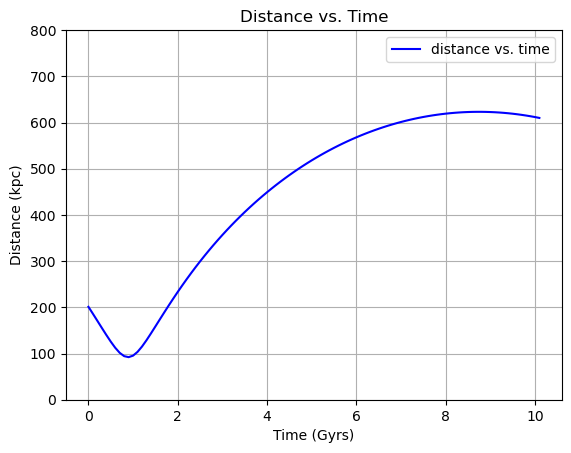

In [12]:
# makes the distance vs. time graph using the lists distance and time
plt.plot(time,distance, linestyle='-', color='blue', label = 'distance vs. time')
plt.xlabel("Time (Gyrs)")
plt.ylabel("Distance (kpc)")
plt.title("Distance vs. Time")
plt.ylim(0,800)
plt.grid(True)
plt.legend()
plt.show()

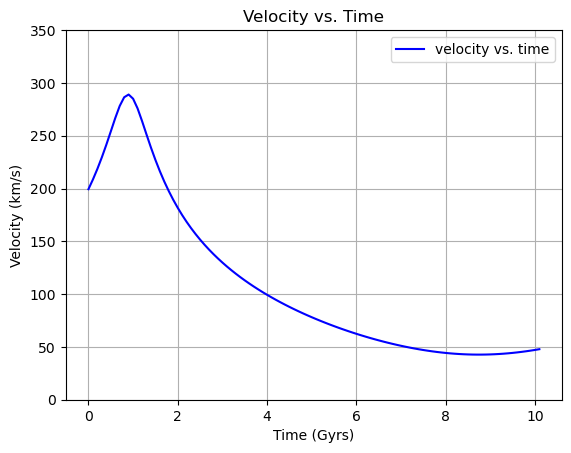

In [18]:
# makes the velocity vs. time graph using the lists velocity and time
plt.plot(time,velocity, linestyle='-', color='blue', label = 'velocity vs. time')
plt.xlabel("Time (Gyrs)")
plt.ylabel("Velocity (km/s)")
plt.title("Velocity vs. Time")
plt.ylim(0,350)
plt.grid(True)
plt.legend()
plt.show()

In [20]:
#Gets the data from HW6, Orbit_COM
dataM31 = np.genfromtxt("orbit_M31.txt",dtype=None,names=True)
dataM33 = np.genfromtxt("orbit_M33.txt",dtype=None,names=True)

In [22]:
# This is the function from Orbit_COM that I used to make the graphs in HW 6

def dvectors(file1,file2):
    """
    This function loops over the datafiles for position and velocity vectors of two galaxies and creates 2
    lists that represents how the magnitudes of the distance and velocity between the two galaxies change over time
    Inputs:
        file1: the file containing the time, position, and velocity data for one of the galaxies
        file2: the file containing the time, position, and velocity data for the other galaxy

    Outputs:
        dis: A list containing the distance between two galaxies over time
        vel: A list containing the velcoity between two galaxies over time
    """
    dist = np.zeros(len(file1))
    vdist = np.zeros(len(file1))
    time = np.zeros(len(file1))
    for i in range(len(file1)):
        # Gathers position and velocity data for each point in time 
        x1 = file1[i][1]
        y1 = file1[i][2]
        z1 = file1[i][3]
        vx1 = file1[i][4]
        vy1 = file1[i][5]
        vz1 = file1[i][6]
        x2 = file2[i][1]
        y2 = file2[i][2]
        z2 = file2[i][3]
        vx2 = file2[i][4]
        vy2 = file2[i][5]
        vz2 = file2[i][6]
        t1 = file1[i][0] *1e-3
        # Computes the magnitudes of distance and velocity for each galaxy and stores them
        # as a data point on an array
        dist[i] = np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
        vdist[i] = np.sqrt((vx1-vx2)**2+(vy1-vy2)**2+(vz1-vz2)**2)
        time[i] = t1
        #converts arrays to lists
        tim = time.tolist()
        dis = dist.tolist()
        vel = vdist.tolist()
    return dis,vel,tim
        

In [24]:
# Calls on dvectors to make the data from Orbit_COM for M31 and M33 more easily graphable
M3133 = dvectors(dataM31,dataM33)

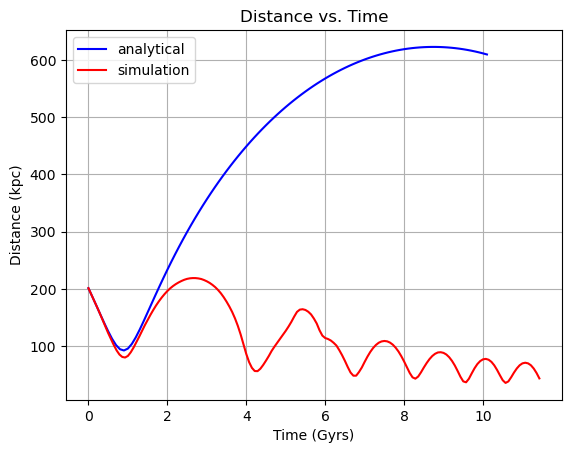

In [26]:
# Question 1a
# graphs the Analytical and the Simulation distance vs time graphs over eachother
distances2 = M3133[0] # gets the distances from M3133
time_2 = M3133[2] # gets the times from M3133
plt.plot(time,distance, linestyle='-', color='blue', label = 'analytical')
plt.plot(time_2,distances2, linestyle='-', color='red', label = 'simulation')
plt.xlabel("Time (Gyrs)")
plt.ylabel("Distance (kpc)")
plt.title("Distance vs. Time")
#plt.ylim(0,800)
plt.grid(True)
plt.legend()
plt.show()

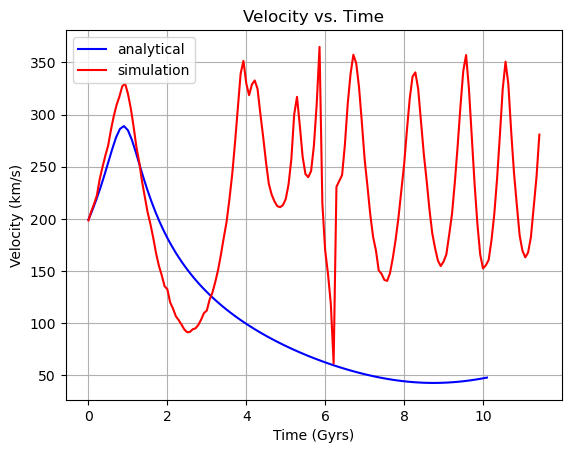

In [28]:
#Question 1b
# graphs the Analytical and the Simulation velocity vs time graphs over eachother
velocities2 = M3133[1] # gets the velocities from M3133
plt.plot(time,velocity, linestyle='-', color='blue', label = 'analytical')
plt.plot(time_2,velocities2, linestyle='-', color='red', label = 'simulation')
plt.xlabel("Time (Gyrs)")
plt.ylabel("Velocity (km/s)")
plt.title("Velocity vs. Time")
#plt.ylim(0,600)
plt.grid(True)
plt.legend()
plt.show()

In [30]:
# Question 2
# the graphs are very simijlar for the first 1.5 Gigayears
# after that, the analytical solution has one long curve for distance and velocity, while the simulation has several
# oscillations in both distance and velocity

In [32]:
# Question 3
#The interaction of gasses could slow down the galaxies, causing more velocity loss than we are currently accounting for analytically

In [34]:
# Question 4
# This would require all of the equations to be adjusted to match the 3 body problem